# Histopathologic Cancer Detection

The aim is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. We detect cancer by identifying metastatic tissue in histopathologic scans of lymph nodes using Deep Learning.

### What is Histopathology?

Histopathology is the diagnosis and study of diseases of the tissues, and involves examining tissues and/or cells under a microscope. It is the study of the signs of the disease using the microscopic examination of a biopsy or surgical specimen that is processed and fixed onto glass slides. To visualize different components of the tissue under a microscope, the sections are dyed with one or more stains.

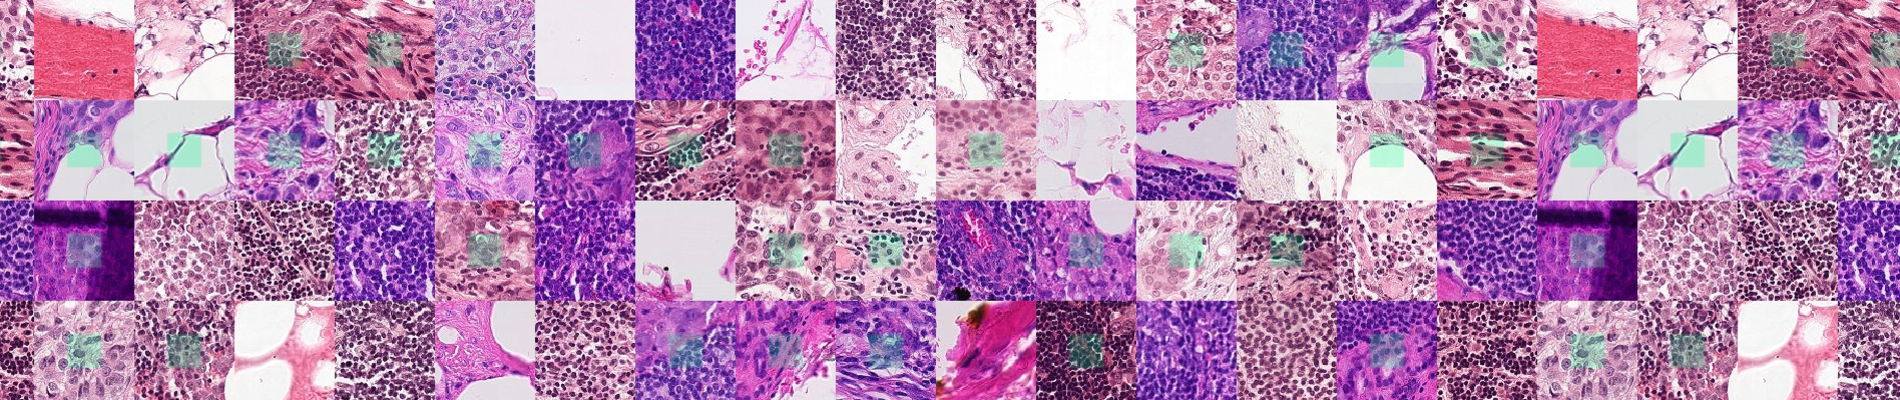

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer.
The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed. Hence using Deep Learning and Machine Learning Models provide an efficient alternative.

## Dataset

The dataset is a slightly modified version of the PatchCamelyon benchmark dataset. The original PCam dataset contains duplicate images due to its probabilistic sampling, however, this does not contain duplicates.

It can be downloaded here: https://www.kaggle.com/c/histopathologic-cancer-detection/data

The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU.

PCam packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

The data has 2 folders of training and testing images and a file of training labels.

## Load the required libraries

In [2]:
!pip install scikit-image keras livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 27.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 8.0 MB/s eta 0:00:00


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob 
import cv2
from skimage.io import imread 
import os
import shutil
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

## Data Exploration

In [7]:
#load the dataset and look at the number of training and testing examples

print('Train Images = ',len(os.listdir('./train/')))
print('Test Images = ',len(os.listdir('./test/')))

Train Images =  220025
Test Images =  57458


In [8]:
#create a dataframe of train image labels

df = pd.read_csv('./train_labels.csv')
print('Shape of DataFrame',df.shape)

df.head()

Shape of DataFrame (220025, 2)


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

We are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

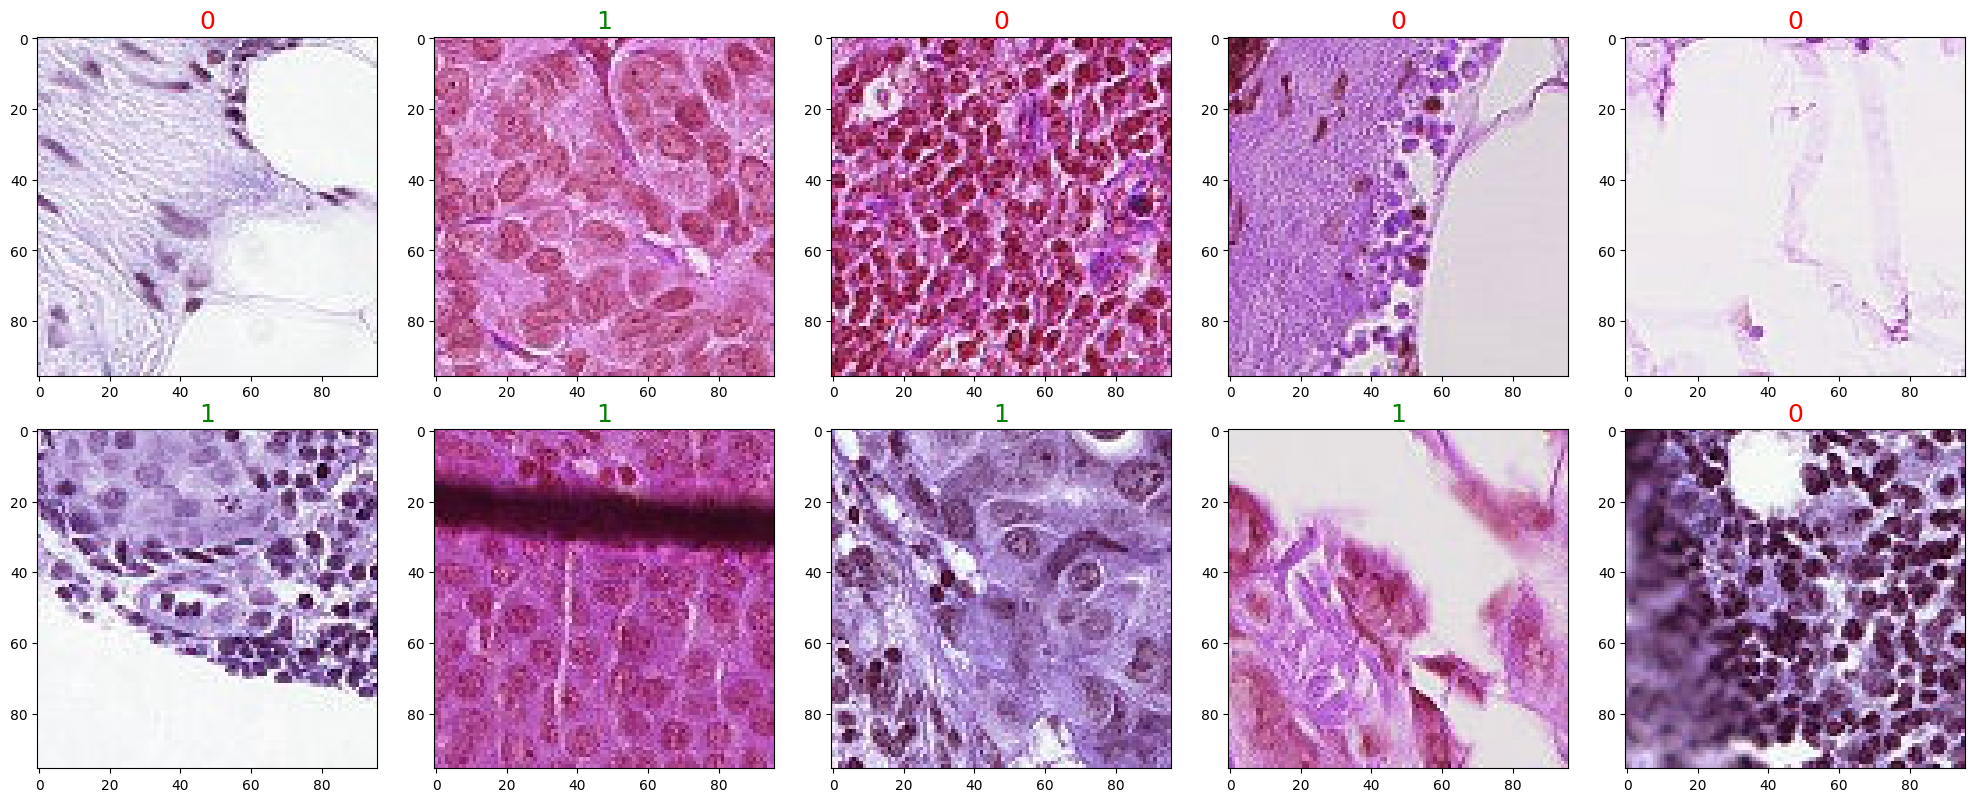

In [9]:
#visualise training examples
training_dir = './train/'

fig = plt.figure(figsize = (20,8))
index = 1
for i in np.random.randint(low = 0, high = df.shape[0], size = 10):
    file = training_dir + df.iloc[i]['id'] + '.tif'
    img = cv2.imread(file)
    ax = fig.add_subplot(2, 5, index)
    ax.imshow(img, cmap = 'gray')
    index = index + 1
    color = ['green' if df.iloc[i].label == 1 else 'red'][0]
    ax.set_title(df.iloc[i].label, fontsize = 18, color = color)
plt.tight_layout()
plt.show()

## Feature engineering


In [10]:
# take a sample size of 85000 to avoid crashing
SAMPLE_SIZE = 85000

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 0)
# filter out class 1
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 0)

# concat the dataframes
df_train = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)

# shuffle
df_train.sample(frac=1)

df_train['label'].value_counts()

label
0    85000
1    85000
Name: count, dtype: int64

In [11]:
df_train.head()

id  label
0  4d03f037381aa81370f4ef724cece830910be6e2      0
1  fe6129053d73422aa1c3ba03b41deacf68d2d27b      0
2  dd752745021474b0752095c8d6c8af72ea9f40ea      0
3  514deb337e49c9ba0cc3d20f990b47799059c72c      0
4  4a20631d20270b4b5e97eaeeba85e9b7f09337af      0

In [12]:
df_train.tail()

id  label
169995  465a70e648cd5f414e584798d349f603a584980e      1
169996  d1a0ca789344beabd2e4c7f26a3f0ec6251daf98      1
169997  970530056fad2be4b994d07f3142317a3bc65986      1
169998  05ce96e76de1558ada854e01ac6a0f5a926c04f6      1
169999  3b3cded61e61f33b91bdfa0a9aab73f6ad0da7be      1

In [13]:
# split into training and validation sets
y = df_train['label']
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state = 0, stratify = y)

In [14]:
# Create a new directory
b_dir = 'b_dir'
os.mkdir(b_dir)


#Folder Structure

'''
    * b_dir
        |-- trn_dir
            |-- 0   #No Tumor (negative)
            |-- 1   #Has Tumor (positive)
        |-- v_dir
            |-- 0
            |-- 1
'''
# create a path to 'b_dir' to which we will join the names of the new folders
# trn_dir
trn_dir = os.path.join(b_dir, 'trn_dir')
os.mkdir(trn_dir)

# v_dir
v_dir = os.path.join(b_dir, 'v_dir')
os.mkdir(v_dir)

# create new folders inside trn_dir
neg = os.path.join(trn_dir, '0')
os.mkdir(neg)
pos = os.path.join(trn_dir, '1')
os.mkdir(pos)


# create new folders inside v_dir
neg = os.path.join(v_dir, '0')
os.mkdir(neg)
pos = os.path.join(v_dir, '1')
os.mkdir(pos)

print(os.listdir('b_dir/trn_dir'))
print(os.listdir('b_dir/v_dir'))

['0', '1']
['0', '1']


In [17]:
df

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

In [18]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.set_index('id').loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = '0'
    elif target == 1:
        label = '1'
    
    # source path to image
    src = os.path.join('./train', file_name)
    # destination path to image
    dest = os.path.join(trn_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)

In [21]:
for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.set_index('id').loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = '0'
    elif target == 1:
        label = '1'
    

    # source path to image
    src = os.path.join('./train', file_name)
    # destination path to image
    dest = os.path.join(v_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)

In [22]:
print(len(os.listdir('b_dir/trn_dir/0')))
print(len(os.listdir('b_dir/trn_dir/1')))

76500
76500


In [43]:
print(len(os.listdir('./test/')))

57458


## Data Augmentation

In [23]:
data_augmentation = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       rotation_range=180,
                                       zoom_range=0.4, 
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       shear_range=0.3,
                                       channel_shift_range=0.3)

In [45]:
batch_size = 192
image_size = 96

train_path = 'b_dir/trn_dir'
val_path = 'b_dir/v_dir'
test_path = './test'

train_set = data_augmentation.flow_from_directory(train_path,
                                                            target_size = (image_size,image_size),
                                                            batch_size = batch_size,
                                                            class_mode = 'binary')
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size = (image_size,image_size),
                                                                        batch_size = batch_size,
                                                                        class_mode = 'binary')

Found 153000 images belonging to 2 classes.
Found 17000 images belonging to 2 classes.


In [47]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                           target_size = (image_size,image_size),
                                                                           batch_size = batch_size,
                                                                           class_mode = 'binary',
                                                                           shuffle = False)

Found 57458 images belonging to 1 classes.


In [59]:
test_set.filenames

['0/00006537328c33e284c973d7b39d340809f7271b.tif',
 '0/0000ec92553fda4ce39889f9226ace43cae3364e.tif',
 '0/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif',
 '0/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif',
 '0/000270442cc15af719583a8172c87cd2bd9c7746.tif',
 '0/000309e669fa3b18fb0ed6a253a2850cce751a95.tif',
 '0/000360e0d8358db520b5c7564ac70c5706a0beb0.tif',
 '0/00040095a4a671280aeb66cb0c9231e6216633b5.tif',
 '0/000698b7df308d75ec9559ef473a588c513a68aa.tif',
 '0/0006e1af5670323331d09880924381d67d79eda0.tif',
 '0/000997a6038fa7441aa0111ac456255060a354c4.tif',
 '0/000c8db3e09f1c0f3652117cf84d78aae100e5a7.tif',
 '0/000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe.tif',
 '0/000e6341cf18365d35b40f4991002fec8834afc0.tif',
 '0/0010e2887e0b977fcdfdf4c50564fafbbc2b6208.tif',
 '0/0010e7eaa3d8e14203cd3900b739d8bf0f0b67f0.tif',
 '0/001161a2eca200f565f12870048a78fa5b320dee.tif',
 '0/0011807dd1e3306ff3f7a755fd3efbefa2901dce.tif',
 '0/00118bec91b7fae175791896f7011ff506b3d7dd.tif',
 '0/0011f0596a038fc8daec4fde714

## Model

In [26]:
import tensorflow as tf

In [27]:
input_shape = (image_size, image_size, 3)
inputs = Input(input_shape)

xception = Xception(include_top = False, input_shape= input_shape)(inputs)
mobile_net = MobileNetV2(include_top = False, input_shape= input_shape)(inputs)

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(mobile_net)])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 xception (Functional)       (None, 3, 3, 2048)           2086148   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)           2257984   ['input_4[0][0]']             
 ional)                                                                                           
                                                                                            

/Users/kiro02/Library/Caches/pypoetry/virtualenvs/cub-2023oct-tIHWYxGD-py3.11/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


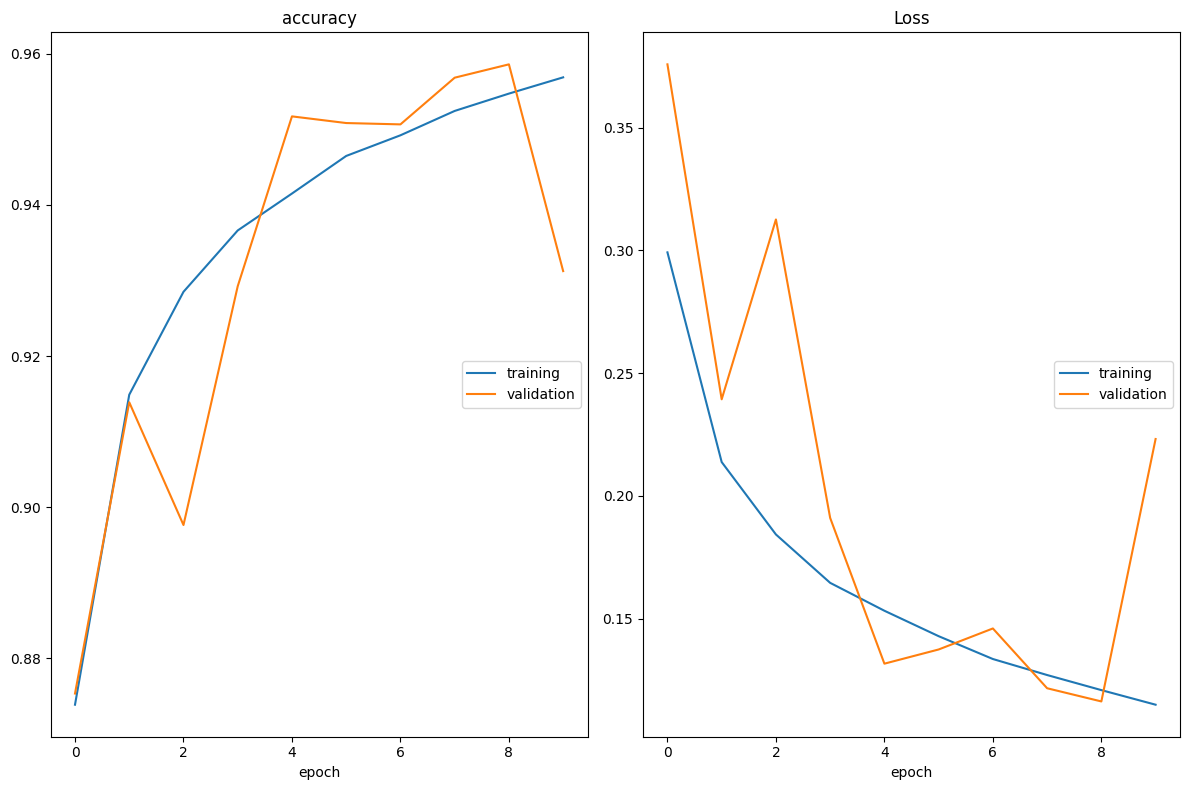

accuracy
	training         	 (min:    0.874, max:    0.957, cur:    0.957)
	validation       	 (min:    0.875, max:    0.959, cur:    0.931)
Loss
	training         	 (min:    0.115, max:    0.299, cur:    0.115)
	validation       	 (min:    0.116, max:    0.376, cur:    0.223)
797/797 [==============================] - 512s 642ms/step - loss: 0.1149 - accuracy: 0.9569 - val_loss: 0.2232 - val_accuracy: 0.9312


In [29]:
with tf.device('/device:GPU:1'):
    history = model.fit_generator(train_set,
                                steps_per_epoch=len(train_set), 
                                validation_data=val_set,
                                validation_steps=len(val_set),
                                epochs=10,
                                verbose=1,
                                callbacks=PlotLossesKeras())

The dataset is such that the outer region of each image is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. Therefore, we need not use ZeroPadding for our model.

## Training

In [34]:
len(val_set)/batch_size

0.4635416666666667

In [36]:
# Training
with tf.device('/device:GPU:1'):
    history = model.fit_generator(train_set, 
                                validation_data=val_set,
                                steps_per_epoch=int(len(train_set)/batch_size) ,
                                validation_steps=int(len(val_set)/batch_size), 
                                epochs = 15,
                                verbose = 1,
                                )

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

/var/folders/_1/_y6lxkm177x0g8qp8xrnnxrh0000gn/T/ipykernel_83845/2673577488.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set,


Epoch 1/15
4/4 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9648

TypeError: Cannot convert 0.4635416666666667 to EagerTensor of dtype int64

In [37]:
model.save('model.h5')

/Users/kiro02/Library/Caches/pypoetry/virtualenvs/cub-2023oct-tIHWYxGD-py3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
pred = model.predict_generator(test_set, steps = len(test_set), verbose = 1)

/var/folders/_1/_y6lxkm177x0g8qp8xrnnxrh0000gn/T/ipykernel_83845/4041748637.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_set, steps = len(test_set), verbose = 1)


300/300 [==============================] - 119s 397ms/step


In [67]:
df_test = pd.read_csv('./sample_submission.csv')
df_test = df_test.drop('label', axis = 1)

In [56]:
(pred > 0.5).astype(int)

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [63]:
filenames = [f[2:] for f in test_set.filenames]

df_pred = pd.DataFrame({'id': filenames, 'label': list(pred > 0.5)})
df_pred['id'] = df_pred['id'].str.replace('.tif', '')
df_pred['label'] = df_pred['label'].astype(int)

df_pred.head()

id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      0
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4  000270442cc15af719583a8172c87cd2bd9c7746      0

In [68]:
df_test = pd.merge(df_test, df_pred, on = 'id')

df_test.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [69]:
df_test.to_csv('submission.csv', index = False)